Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1714]:
import logging
from cgitb import reset
from typing import Callable

import geopy.distance
import pandas as pd
import numpy as np
import numpy.typing as npt
import networkx as nx

from itertools import combinations, cycle

from PIL.features import modules
from matplotlib import pyplot as plt
from icecream import ic
from tqdm import tqdm

logging.basicConfig(level=logging.DEBUG)

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [1715]:
def load_cities(file_name: str) -> (pd.DataFrame, npt.NDArray, nx.Graph):
    cities = pd.read_csv(file_name, header=None, names=['name', 'lat', 'lon'])
    
    dist_matrix = np.zeros((len(cities), len(cities)))
    graph = nx.Graph()
    
    for c1, c2 in combinations(cities.itertuples(), 2):
        distance = geopy.distance.geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    
        dist_matrix[c1.Index, c2.Index] = dist_matrix[c2.Index, c1.Index] = distance
        graph.add_edge(c1.Index, c2.Index, weight=distance)
    
    return cities, dist_matrix, graph

CITIES, DIST_MATRIX, GRAPH = load_cities('italy.csv')

def tsp_cost(path: list[int]) -> float:
    assert path[0] == path[-1]
    assert set(path) == set(range(len(path) - 1))

    tot_cost = 0
    for c1, c2 in zip(path, path[1:]):
        tot_cost += DIST_MATRIX[c1, c2]

    return tot_cost

## NetworkX implementation

The Python library NetworkX provides an implementation for the Traveling Salesman problem on a graph

In [1716]:
nx_path = nx.approximation.traveling_salesman_problem(GRAPH)

tsp_cost(nx_path)

np.float64(4485.166040259443)

## First greedy algorithm

Starting from a city, for each iteration visits the closest city.

In [1717]:
def node_based_greedy_tsp(initial_city: int = 0, verbose: bool = False) -> list[int]:
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    
    city = initial_city
    visited[city] = True
    
    path = [city]
    
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        
        if verbose:
            logging.debug(
                f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
            )
        
        visited[closest] = True
        city = closest
        
        path.append(int(city))
    
    if verbose:
        logging.debug(
            f"step: {CITIES.at[path[-1],'name']} -> {CITIES.at[path[0],'name']} ({DIST_MATRIX[path[-1],path[0]]:.2f}km)"
        )
    
    path.append(path[0])
    return path

tsp_cost(node_based_greedy_tsp())

np.float64(4436.03176952516)

# Hill climber

3 possible mutations for a given path are defined.

In [1718]:

def scramble_mutation(path: list[int], weight: float = 0.5) -> list[int]:
    modified_path = np.array(path[:-1])
    
    # Random portion of code, uses a weight.
    mask = np.random.rand(len(path) - 1) < weight
    selected_loci = modified_path[mask]
    
    np.random.shuffle(selected_loci)
    modified_path[mask] = selected_loci
    modified_path = np.append(modified_path, [modified_path[0]])
    
    return modified_path.tolist()

def insert_mutation(path: list[int], _: float = 0.0) -> list[int]:
    modified_path = np.array(path[:-1])
    
    # Random portion of code, maybe it can be weighted in some way.
    selected_loci = np.random.choice(modified_path, 2, replace=False)
    
    sorter = np.argsort(modified_path)
    insert_position = min(sorter[np.searchsorted(modified_path, selected_loci, sorter=sorter)])
    insert_value = selected_loci[selected_loci != modified_path[insert_position]][0]
    
    modified_path = np.delete(modified_path, np.where(modified_path == insert_value))
    modified_path = np.insert(modified_path, insert_position + 1, insert_value)
    modified_path = np.append(modified_path, [modified_path[0]])
    
    return modified_path.tolist()

def inversion_mutation(path: list[int], _: float = 0.0) -> list[int]:
    modified_path = np.array(path[:-1])
    
    # Random portion of code, maybe it can be weighted in some way.
    selected_loci = np.random.choice(modified_path, 2, replace=False)
    
    sorter = np.argsort(modified_path)
    loci_positions = sorter[np.searchsorted(modified_path, selected_loci, sorter=sorter)]
    sorted_loci_position = np.sort(loci_positions)
    
    selected_part = modified_path[sorted_loci_position[0] : sorted_loci_position[1]]
    selected_part = np.append(selected_part, modified_path[sorted_loci_position[1]])
    
    modified_path = np.delete(modified_path, np.s_[sorted_loci_position[0]:sorted_loci_position[1] + 1])
    modified_path = np.insert(modified_path, sorted_loci_position[0], selected_part[::-1])
    modified_path = np.append(modified_path, [modified_path[0]])
    
    return modified_path.tolist()
    

In [1719]:
def hill_climber(num_steps: int, tweak_function: Callable[[list[int], float], list[int]], initial_city: int = np.random.randint(len(CITIES)), verbose: bool = True) -> list[int]:
    current_path = node_based_greedy_tsp(initial_city)
    history = [tsp_cost(current_path)]
    
    if verbose:
        print(current_path)
    
    step_range = range(num_steps)
    if verbose:
        step_range = tqdm(step_range)
    
    for _ in step_range:        
        new_path = tweak_function(current_path.copy(), 0.5)
        history.append(tsp_cost(new_path))
        
        if tsp_cost(new_path) < tsp_cost(current_path):
            current_path = new_path
    
    if verbose:
        plt.plot(range(len(history)), history, label='Cost')
        print(tsp_cost(current_path))
    
    return current_path

## Results

We could compute the results of the Hill Climbing algorithm with every possible initial path (i.e. computing it one time for every path that starts in a different city).
In this case, the number of computations required is given by num_steps * num_cities.

Alternatively, we execute the algorithm only 1 time, with a random starting city for the initial path.

[28, 25, 32, 19, 4, 9, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 16, 29, 10, 12, 30, 33, 0, 26, 39, 34, 15, 14, 21, 35, 11, 1, 2, 38, 17, 31, 8, 37, 24, 7, 36, 27, 41, 43, 40, 5, 28]


100%|██████████| 1000000/1000000 [01:39<00:00, 10038.62it/s]


4432.206161647443
4432.21


100%|██████████| 46/46 [00:44<00:00,  1.02it/s]


Total cost: 4174.94km


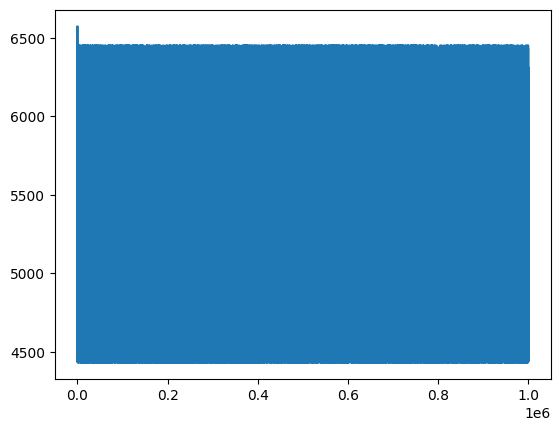

In [1720]:
# Single execution, with more steps.
print(f"{tsp_cost(hill_climber(1000000, inversion_mutation)):.2f}")

# 1 execution per city, with fewer steps to not increase the computation time too much.
results = []
for city in tqdm(range(len(CITIES))):
    final_path = hill_climber(10000, inversion_mutation, city, verbose=False)
    
    results.append((city, final_path, tsp_cost(final_path)))

best_result = sorted(results, key=lambda result: result[2])[0]

print(f"Total cost: {best_result[2]:.2f}km")
#print("Path:")
#for i in range(len(CITIES)):
#    print(f"{CITIES.name[best_result[1][i]]} -> {CITIES.name[best_result[1][i + 1]]}")